#DESAFÍO Nro. 4 NLP: predicción de la próxima palabra con redes neuronales LSTM.

Las modificaciones realizadas en relación con el ejercicio original fueron:

* Se cambia el corpus.
* Se compara una arquitectura simple sin bidireccionalidad con otros tres modelos: uno de arquitectura más compleja (con mayor profundidad y más neuronas), otro con bidireccionalidad, y por último, uno que combina ambos.
* Se obtienen conclusiones.


By Anahi Bazet

# Objetivo


El objetivo es utilizar un corpus para entrenar una red neuronal LSTM, y así predecir una palabra en su contexto asociado. 

Se elige el libro "Harry Potter y La piedra filosofal", primero de la saga, de la autora J.K. Rowling para entrenar el modelo, de manera tal que la predicción de la palabra va a estar relacionada con el contexto de la historia dada en el libro.

## 1 - Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [3]:
import gdown
import gradio as gr
import os
import pandas as pd
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2 - Obtención de datos
Se utiliza como dataset los libros de Harry Potter de la autora J.K. Rowling.

In [4]:
#Descargar el archivo del GD y descomprimirlo.
if os.access('HarryPotter.zip', os.F_OK) is False:
  url = 'https://drive.google.com/uc?id=1AbB-v6xB_XeOGVziawDNLY_IQYeeJR3n'
  output = 'HarryPotter.zip'
  gdown.download(url, output, quiet=False)
  !unzip /content/HarryPotter.zip -d /content/HarryPotter
else:
    print("El dataset ya se encuentra descargado.")

El dataset ya se encuentra descargado.


In [5]:
# Lista de libros + CSV de personajes.
os.listdir("./HarryPotter")

['Book2.txt',
 'Book1.txt',
 'Book4.txt',
 'Book5.txt',
 'characters_list.csv',
 'Book3.txt',
 'Book7.txt',
 'Book6.txt']

In [6]:
# Armar el dataset utilizando el salto de línea para separar los documentos.
# Se elige el primer libro.
df = pd.read_csv('HarryPotter/Book1.txt', sep='/n', engine='python', header=None)
df.head(15)

,0
0,/
1,THE BOY WHO LIVED
2,"Mr. and Mrs. Dursley, of number four, Privet D..."
3,were proud to say that they were perfectly nor...
4,thank you very much. They were the last people...
5,expect to be involved in anything strange or
6,"mysterious, because they just didn’t hold with..."
7,nonsense.
8,Mr. Dursley was the director of a firm called
9,"Grunnings, which made drills. He was a big, beefy"


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10144


## 3 - Preprocesamiento

In [8]:
# Vistazo a las primeras filas.
df.loc[:15,0]

0                                                     /
1                                     THE BOY WHO LIVED
2     Mr. and Mrs. Dursley, of number four, Privet D...
3     were proud to say that they were perfectly nor...
4     thank you very much. They were the last people...
5          expect to be involved in anything strange or
6     mysterious, because they just didn’t hold with...
7                                             nonsense.
8         Mr. Dursley was the director of a firm called
9     Grunnings, which made drills. He was a big, beefy
10     man with hardly any neck, although he did have a
11       very large mustache. Mrs. Dursley was thin and
12      blonde and had nearly twice the usual amount of
13      neck, which came in very useful as she spent so
14    much of her time craning over garden fences, s...
15      on the neighbors. The Dursley s had a small son
Name: 0, dtype: object

In [9]:
# Se concatenan todas las filas para obtener el corpus.
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'/ THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley’s sister, but they hadn’t

In [10]:
# Transformar el corpus a tokens.
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens.
tokens[85050:85066]

['with',
 'dudley',
 'this',
 'summer',
 '”',
 'page',
 '348',
 'harry',
 'potter',
 'and',
 'the',
 'philosophers',
 'stone',
 'j',
 'k',
 'rowling']

In [11]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 85066


In [12]:
# Se realiza el desfazaje de los tokens según el tamaño del
# entrenamiento deseado (train_len).
# En este caso son cuatro tokens con desfazaje de una posición.
train_len=4
text_sequences = []
for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [13]:
# Vistazo de los vectores para entrenar el modelo.
text_sequences[85050:85063]

[['with', 'dudley', 'this', 'summer'],
 ['dudley', 'this', 'summer', '”'],
 ['this', 'summer', '”', 'page'],
 ['summer', '”', 'page', '348'],
 ['”', 'page', '348', 'harry'],
 ['page', '348', 'harry', 'potter'],
 ['348', 'harry', 'potter', 'and'],
 ['harry', 'potter', 'and', 'the'],
 ['potter', 'and', 'the', 'philosophers'],
 ['and', 'the', 'philosophers', 'stone'],
 ['the', 'philosophers', 'stone', 'j'],
 ['philosophers', 'stone', 'j', 'k'],
 ['stone', 'j', 'k', 'rowling']]

In [14]:
print (len(text_sequences))

85063


In [15]:
# Proceso de tokenización.
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Se convierten las palabras a números.
sequences = tok.texts_to_sequences(text_sequences)

# Vistazo.
sequences[85050:85063]

[[27, 101, 49, 1210],
 [101, 49, 1210, 2],
 [49, 1210, 2, 35],
 [1210, 2, 35, 6783],
 [2, 35, 6783, 6],
 [35, 6783, 6, 24],
 [6783, 6, 24, 3],
 [6, 24, 3, 1],
 [24, 3, 1, 36],
 [3, 1, 36, 26],
 [1, 36, 26, 37],
 [36, 26, 37, 34],
 [26, 37, 34, 38]]

In [16]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 85063


## 3 - Input y target

In [17]:
arr_sequences = np.array(sequences)
#Todas las columnas menos la última (para todos los elementos).
x_data = arr_sequences[:,:-1]
#La última columna (para todos los elementos).
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(85063, 3)
(85063,)


In [18]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: '”',
 3: 'and',
 4: 'to',
 5: 'a',
 6: 'harry',
 7: 'he',
 8: 'of',
 9: 'was',
 10: 'it',
 11: 'in',
 12: 'his',
 13: '—',
 14: 'you',
 15: 'said',
 16: 'had',
 17: 'on',
 18: 'at',
 19: 'they',
 20: 'that',
 21: 'as',
 22: 'him',
 23: 'i',
 24: 'potter',
 25: 'but',
 26: 'stone',
 27: 'with',
 28: 'ron',
 29: 'all',
 30: 'out',
 31: 'up',
 32: 'for',
 33: 'be',
 34: 'k',
 35: 'page',
 36: 'philosophers',
 37: 'j',
 38: 'rowling',
 39: 'hagrid',
 40: 'them',
 41: 'were',
 42: 'have',
 43: 'what',
 44: 'there',
 45: 'back',
 46: 'hermione',
 47: 'one',
 48: 'from',
 49: 'this',
 50: 'not',
 51: 'if',
 52: 'she',
 53: 'about',
 54: 'into',
 55: 'their',
 56: 'me',
 57: 'know',
 58: 'been',
 59: 'so',
 60: 'off',
 61: 'didn’t',
 62: 'could',
 63: 'like',
 64: 'got',
 65: 'get',
 66: 'down',
 67: '“i',
 68: 'her',
 69: 'when',
 70: 'who',
 71: 'over',
 72: 'looked',
 73: 'professor',
 74: 'see',
 75: 'just',
 76: 'very',
 77: 'is',
 78: 'then',
 79: 'no',
 80: 'do',
 81: 'by

In [19]:
# Cantidad de palabras en el vocabulario.
vocab_size = len(tok.word_counts)
vocab_size

6783

In [20]:
# Valor minimo del vocabulario.
print (min(y_data_int))
# Valor máximo del vocabulario.
print (max(y_data_int))

1
6783


In [21]:
#Cada target tiene un 1 en la posición de la palabra y cero en las restantes.
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(85063, 6783)

In [22]:
#Ejemplo para el target:
print (text_sequences[85062:85063])
print (sequences[85062:85063])
print (x_data[85062,:])
print (y_data[85062,30:38])
# En la posición 37 (elemento 38) se encuentra el 1 del OHE.

[['stone', 'j', 'k', 'rowling']]
[[26, 37, 34, 38]]
[26 37 34]
[0. 0. 0. 0. 0. 0. 0. 1.]


## 4 - Primer modelo: sin bidirectional y con arquitectura simple (modelo base)

Es el modelo inicial que se tomará de baseline.

### 4.A - Diseñar y entrenar el modelo

In [23]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [24]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6783

In [25]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras.
# input_dim = vocab_size --> 6783 palabras distintas.
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable).
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
#input_length=3, porque la siguiente capa consume de a 3 palabras (3 embeddings). 
#Es decir, se pasa de un índice de 6783 elementos a un vector de 5 elementos.

model.add(LSTM(64, return_sequences=True))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences.
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax.
# La salida vuelve al espacio de 6783 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              33920     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6783)              223839    
                                                                 
Total params: 310,783
Trainable params: 310,783
Non-trai

In [26]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2127/2127 [==============================] - 37s 15ms/step - loss: 6.7803 - accuracy: 0.0463 - val_loss: 6.6373 - val_accuracy: 0.0431
Epoch 2/50
2127/2127 [==============================] - 21s 10ms/step - loss: 6.3601 - accuracy: 0.0602 - val_loss: 6.4571 - val_accuracy: 0.0771
Epoch 3/50
2127/2127 [==============================] - 22s 10ms/step - loss: 6.0731 - accuracy: 0.0851 - val_loss: 6.4114 - val_accuracy: 0.0833
Epoch 4/50
2127/2127 [==============================] - 21s 10ms/step - loss: 5.8940 - accuracy: 0.0952 - val_loss: 6.3532 - val_accuracy: 0.1037
Epoch 5/50
2127/2127 [==============================] - 21s 10ms/step - loss: 5.7200 - accuracy: 0.1096 - val_loss: 6.3615 - val_accuracy: 0.1107
Epoch 6/50
2127/2127 [==============================] - 21s 10ms/step - loss: 5.5413 - accuracy: 0.1241 - val_loss: 6.3576 - val_accuracy: 0.1215
Epoch 7/50
2127/2127 [==============================] - 21s 10ms/step - loss: 5.3827 - accuracy: 0.1337 - val_loss: 6.3505 -

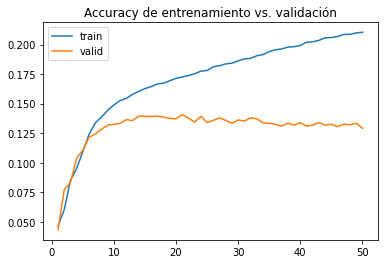

In [27]:
# Accuracy de entrenamiento vs. validación
epoch_count = range(1, len(hist.history['accuracy']) + 1)
acc_train=hist.history['accuracy']
acc_valid=hist.history['val_accuracy']
sns.lineplot(x=epoch_count,  y=acc_train, label='train')
sns.lineplot(x=epoch_count,  y=acc_valid, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.show()

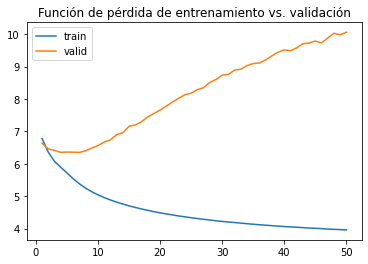

In [28]:
# Función de pérdida de entrenamiento vs. validación
loss_train=hist.history['loss']
loss_valid=hist.history['val_loss']
sns.lineplot(x=epoch_count,  y=loss_train, label='train')
sns.lineplot(x=epoch_count,  y=loss_valid, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.show()

### 4.B - Generación de secuencias nuevas

In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# Generar un número de palabras.
    for _ in range(n_words):
		    # Encodear.
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		    
        # Si tienen distinto largo.
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		    # Predicción softmax.
        y_hat = model.predict(encoded).argmax(axis=-1)
		    
        # Inicializar la palabra predecida.
        out_word = ''

        # Buscar en el vocabulario la palabra
        # que corresponde al indice (y_hat) predicho por el modelo.
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		    # Agregar la palabra a la frase predicha.
        output_text += ' ' + out_word
    return output_text

In [87]:
input_text='Hermione always liked'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

'Hermione always liked and the better'

### 4.C - Predicción de próxima palabra

Solo para este modelo, se muesra un ejemplo utilizando Gradio.

In [31]:
def model_response(human_text):

    # Encodear.
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo.
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    # Si son más de tres términos lo corta (se queda con los últimos 3).
    # Si ingresa menos de tres términos rellena con ceros los primeros tokens.
    
    # Predicción softmax.
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Buscar en el vocabulario la palabra
    # que corresponde al indice (y_hat) predicho por el modelo.
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agregar la palabra a la frase predicha.
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://27737.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fa04a8f1550>,
 'http://127.0.0.1:7860/',
 'https://27737.gradio.app')

## 5 - Segundo modelo: arquitectura más compleja

### 5.A - Diseñar y entrenar el modelo

In [32]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [33]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6783

In [34]:
model_arq = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras.
# input_dim = vocab_size --> 6783 palabras distintas.
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable).
model_arq.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
#input_length=3, porque la siguiente capa consume de a 3 palabras (3 embeddings). 
#Es decir, se pasa de un índice de 6783 elementos a un vector de 5 elementos.

model_arq.add(LSTM(128, return_sequences=True))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model_arq.add(Dropout(0.2))
model_arq.add(LSTM(128, return_sequences=True))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model_arq.add(Dropout(0.2))
model_arq.add(LSTM(64)) # La última capa LSTM no lleva return_sequences.
model_arq.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax.
# La salida vuelve al espacio de 6783 palabras posibles
model_arq.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy.
model_arq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_arq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              33920     
                                                                 
 lstm_2 (LSTM)               (None, 3, 128)            68608     
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)               

In [35]:
hist_arq = model_arq.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2127/2127 [==============================] - 52s 23ms/step - loss: 6.7855 - accuracy: 0.0468 - val_loss: 6.6425 - val_accuracy: 0.0431
Epoch 2/50
2127/2127 [==============================] - 45s 21ms/step - loss: 6.4100 - accuracy: 0.0569 - val_loss: 6.4976 - val_accuracy: 0.0729
Epoch 3/50
2127/2127 [==============================] - 46s 22ms/step - loss: 6.1419 - accuracy: 0.0828 - val_loss: 6.4042 - val_accuracy: 0.0848
Epoch 4/50
2127/2127 [==============================] - 46s 22ms/step - loss: 5.9265 - accuracy: 0.0939 - val_loss: 6.3618 - val_accuracy: 0.0930
Epoch 5/50
2127/2127 [==============================] - 45s 21ms/step - loss: 5.7668 - accuracy: 0.1052 - val_loss: 6.3545 - val_accuracy: 0.1044
Epoch 6/50
2127/2127 [==============================] - 44s 21ms/step - loss: 5.6221 - accuracy: 0.1157 - val_loss: 6.4210 - val_accuracy: 0.1085
Epoch 7/50
2127/2127 [==============================] - 45s 21ms/step - loss: 5.5004 - accuracy: 0.1258 - val_loss: 6.4147 -

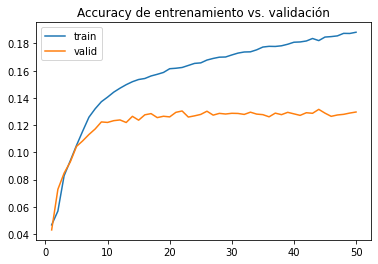

In [36]:
# Accuracy de entrenamiento vs. validación
epoch_count_arq = range(1, len(hist_arq.history['accuracy']) + 1)
acc_train_arq=hist_arq.history['accuracy']
acc_valid_arq=hist_arq.history['val_accuracy']
sns.lineplot(x=epoch_count_arq,  y=acc_train_arq, label='train')
sns.lineplot(x=epoch_count_arq,  y=acc_valid_arq, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.show()

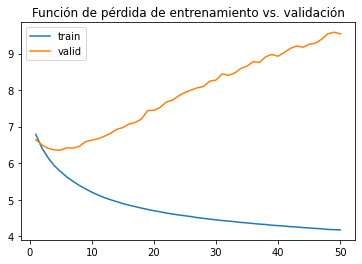

In [37]:
# Función de pérdida de entrenamiento vs. validación
loss_train_arq=hist_arq.history['loss']
loss_valid_arq=hist_arq.history['val_loss']
sns.lineplot(x=epoch_count_arq,  y=loss_train_arq, label='train')
sns.lineplot(x=epoch_count_arq,  y=loss_valid_arq, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.show()

### 5.B - Generación de secuencias nuevas

In [88]:
input_text='Hermione always liked'

generate_seq(model_arq, tok, input_text, max_length=3, n_words=3)

'Hermione always liked and  '

## 6 - Tercer modelo: con bidirectional

### 6.A - Diseñar y entrenar el modelo

In [39]:
model_bid = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras.
# input_dim = vocab_size --> 6783 palabras distintas.
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable).
model_bid.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
#input_length=3, porque la siguiente capa consume de a 3 palabras (3 embeddings). 
#Es decir, se pasa de un índice de 6783 elementos a un vector de 5 elementos.

model_bid.add(Bidirectional(LSTM(64, return_sequences=True)))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model_bid.add(Dropout(0.2))
model_bid.add(Bidirectional(LSTM(64))) # La última capa LSTM no lleva return_sequences.
model_bid.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax.
# La salida vuelve al espacio de 6783 palabras posibles
model_bid.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy.
model_bid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bid.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              33920     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           35840     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 6783)             

In [40]:
hist_bid = model_bid.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2127/2127 [==============================] - 34s 14ms/step - loss: 6.6678 - accuracy: 0.0492 - val_loss: 6.4504 - val_accuracy: 0.0555
Epoch 2/50
2127/2127 [==============================] - 27s 13ms/step - loss: 6.1571 - accuracy: 0.0693 - val_loss: 6.3591 - val_accuracy: 0.0761
Epoch 3/50
2127/2127 [==============================] - 27s 13ms/step - loss: 5.9379 - accuracy: 0.0871 - val_loss: 6.3416 - val_accuracy: 0.0935
Epoch 4/50
2127/2127 [==============================] - 27s 13ms/step - loss: 5.7612 - accuracy: 0.1028 - val_loss: 6.3605 - val_accuracy: 0.1007
Epoch 5/50
2127/2127 [==============================] - 27s 13ms/step - loss: 5.5762 - accuracy: 0.1205 - val_loss: 6.2878 - val_accuracy: 0.1206
Epoch 6/50
2127/2127 [==============================] - 28s 13ms/step - loss: 5.3931 - accuracy: 0.1357 - val_loss: 6.3161 - val_accuracy: 0.1272
Epoch 7/50
2127/2127 [==============================] - 28s 13ms/step - loss: 5.2467 - accuracy: 0.1440 - val_loss: 6.3439 -

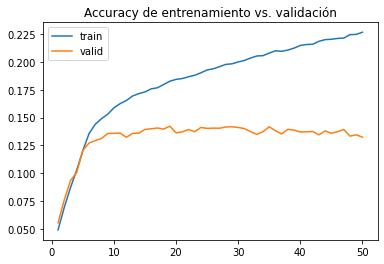

In [41]:
# Accuracy de entrenamiento vs. validación
epoch_count_bid = range(1, len(hist_bid.history['accuracy']) + 1)
acc_train_bid=hist_bid.history['accuracy']
acc_valid_bid=hist_bid.history['val_accuracy']
sns.lineplot(x=epoch_count_bid, y=acc_train_bid, label='train')
sns.lineplot(x=epoch_count_bid, y=acc_valid_bid, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.show()

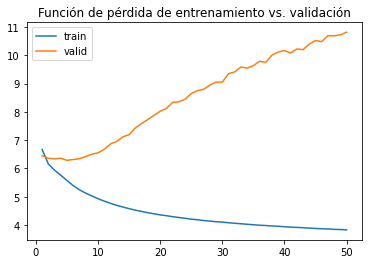

In [42]:
# Función de pérdida de entrenamiento vs. validación
loss_train_bid=hist_bid.history['loss']
loss_valid_bid=hist_bid.history['val_loss']
sns.lineplot(x=epoch_count_bid,  y=loss_train_bid, label='train')
sns.lineplot(x=epoch_count_bid,  y=loss_valid_bid, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.show()

### 6.B - Generación de secuencias nuevas

In [89]:
input_text='Hermione always liked'

generate_seq(model_bid, tok, input_text, max_length=3, n_words=3)

'Hermione always liked they said and'

## 7 - Cuarto modelo: arquitectura más compleja con bidirectional

Es la combinación de los dos modelos anteriores.

### 7.A - Diseñar y entrenar el modelo

In [56]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [45]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6783

In [46]:
model_comb = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras.
# input_dim = vocab_size --> 6783 palabras distintas.
# output_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable).
model_comb.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
#input_length=3, porque la siguiente capa consume de a 3 palabras (3 embeddings). 
#Es decir, se pasa de un índice de 6783 elementos a un vector de 5 elementos.

model_comb.add(Bidirectional(LSTM(128, return_sequences=True)))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model_comb.add(Dropout(0.2))
model_comb.add(Bidirectional(LSTM(128, return_sequences=True)))
# return_sequences=True es para poder colocar otra unidad recurrente luego.
model_comb.add(Dropout(0.2))
model_comb.add(Bidirectional(LSTM(64))) # La última capa LSTM no lleva return_sequences.
model_comb.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax.
# La salida vuelve al espacio de 6783 palabras posibles
model_comb.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy.
model_comb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comb.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              33920     
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 256)           137216    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 256)           394240    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)             

In [47]:
hist_comb = model_comb.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2127/2127 [==============================] - 98s 43ms/step - loss: 6.6082 - accuracy: 0.0494 - val_loss: 6.4378 - val_accuracy: 0.0553
Epoch 2/50
2127/2127 [==============================] - 85s 40ms/step - loss: 6.1134 - accuracy: 0.0699 - val_loss: 6.3147 - val_accuracy: 0.0791
Epoch 3/50
2127/2127 [==============================] - 82s 38ms/step - loss: 5.8448 - accuracy: 0.0953 - val_loss: 6.2443 - val_accuracy: 0.0984
Epoch 4/50
2127/2127 [==============================] - 83s 39ms/step - loss: 5.6234 - accuracy: 0.1159 - val_loss: 6.1721 - val_accuracy: 0.1124
Epoch 5/50
2127/2127 [==============================] - 80s 38ms/step - loss: 5.4657 - accuracy: 0.1268 - val_loss: 6.2073 - val_accuracy: 0.1179
Epoch 6/50
2127/2127 [==============================] - 80s 38ms/step - loss: 5.3499 - accuracy: 0.1344 - val_loss: 6.2509 - val_accuracy: 0.1275
Epoch 7/50
2127/2127 [==============================] - 81s 38ms/step - loss: 5.2538 - accuracy: 0.1407 - val_loss: 6.3053 -

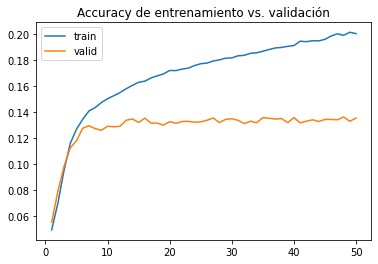

In [48]:
# Accuracy de entrenamiento vs. validación
epoch_count_comb = range(1, len(hist_comb.history['accuracy']) + 1)
acc_train_comb=hist_comb.history['accuracy']
acc_valid_comb=hist_comb.history['val_accuracy']
sns.lineplot(x=epoch_count_comb,  y=acc_train_comb, label='train')
sns.lineplot(x=epoch_count_comb,  y=acc_valid_comb, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.show()

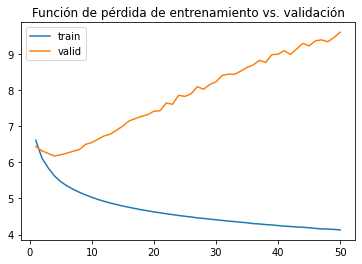

In [49]:
# Función de pérdida de entrenamiento vs. validación
loss_train_comb=hist_comb.history['loss']
loss_valid_comb=hist_comb.history['val_loss']
sns.lineplot(x=epoch_count_comb,  y=loss_train_comb, label='train')
sns.lineplot(x=epoch_count_comb,  y=loss_valid_comb, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.show()

### 7.B - Generación de secuencias nuevas

In [90]:
input_text='Hermione always liked'

generate_seq(model_comb, tok, input_text, max_length=3, n_words=3)

'Hermione always liked and harry of'

## 8 - Conclusiones

### Gráficos

A continuación se comparan las curvas de validación de la función de pérdida y de la métrica de accuracy para los siguientes cuatro modelos:

* Una arquitectura base sencilla con dos capas LSTM sin bidireccionalidad. Esta sería el baseline.
* Una arquitectura más compleja, con 3 capas LSTM y más neuronas, pero sin bidireccionalidad.
* Una arquitectura en donde se aplica bidireccionalidad a la arquitectura base (la primera mencionada).
* Una arquitectura que en donde se aplica bidireccionalidad a la arquitectura compleja (la segunda mencionada).

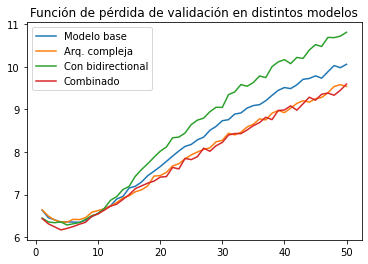

In [51]:
# Función de pérdida de validación en distintos modelos.
sns.lineplot(x=epoch_count_bid,  y=loss_valid, label='Modelo base')
sns.lineplot(x=epoch_count_bid,  y=loss_valid_arq, label='Arq. compleja')
sns.lineplot(x=epoch_count_bid,  y=loss_valid_bid, label='Con bidirectional')
sns.lineplot(x=epoch_count_bid,  y=loss_valid_comb, label='Combinado')
plt.title("Función de pérdida de validación en distintos modelos")
plt.show()

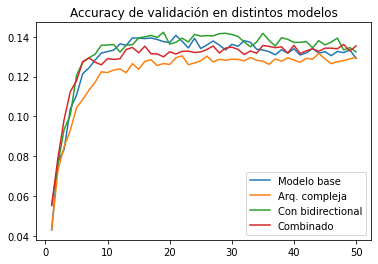

In [53]:
# Accuracy de validación en distintos modelos.
sns.lineplot(x=epoch_count_bid,  y=acc_valid, label='Modelo base')
sns.lineplot(x=epoch_count_bid,  y=acc_valid_arq, label='Arq. compleja')
sns.lineplot(x=epoch_count_bid,  y=acc_valid_bid, label='Con bidirectional')
sns.lineplot(x=epoch_count_bid,  y=acc_valid_comb, label='Combinado')
plt.title("Accuracy de validación en distintos modelos")
plt.show()

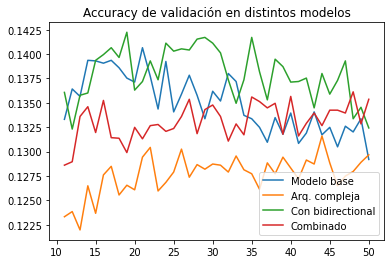

In [55]:
# Accuracy de validación en distintos modelos.
sns.lineplot(x=epoch_count_bid[10:50],  y=acc_valid[10:50], label='Modelo base')
sns.lineplot(x=epoch_count_bid[10:50],  y=acc_valid_arq[10:50], label='Arq. compleja')
sns.lineplot(x=epoch_count_bid[10:50],  y=acc_valid_bid[10:50], label='Con bidirectional')
sns.lineplot(x=epoch_count_bid[10:50],  y=acc_valid_comb[10:50], label='Combinado')
plt.title("Accuracy de validación en distintos modelos")
plt.show()

Como se puede observar en el gráfico, las métricas no son muy buenas en cualquiera de los casos, ya que aunque aumenten las epochs, la curva de accuracy permanece planchada en todos los modelos en valores muy bajos (entre 0.12 y 0.14). No obstante, se ve claramente que al hacer más compleja la arquitectura se obtiene una peor métrica de accuracy. 

Luego, el modelo que utiliza LSTM bidireccionales tiene una métrica de accuracy un poco mejor que la del modelo base. De hecho, es la que mejor performa.

Por último, el modelo que combina mayor profundidad, más cantidad de neuronas y bidireccionalidad, es decir, el que combina las otras dos arquitecturas mencionadas, dependiendo la epoch performa mejor o peor que el modelo base.

### Predicciones

Si comparamos la generación de una secuencia de 3 palabras dada la frase "Hermione always liked..." en cada modelo obtuvimos los siguientes resultados:
* Modelo baseline: Hermione always liked and the better...
* Modelo de arquitectura compleja: Hermione always liked and...
* Modelo con bidireccionalidad: Hermione always liked they said and...
* Modelo combinado: Hermione always liked and Harry of...

Nuevamente, el modelo con bidireccionalidad pareciera que genera la frase con mejor sentido semántico. Mientras que el modelo de arquitectura más compleja solo pudo predecir una palabra (y no las tres solicitadas). Los otros dos modelos, si bien logran generar las 3 palabras, no parecen tener sentido.

Estos resultados están alineados con las conclusiones obtenidas de los gráficos, en donde el mejor modelo es el que posee solo bidireccionalidad y el peor el de la arquitectura más compleja.
